In [1]:
import os
print(os.getcwd())
os.chdir(os.path.join(os.path.dirname(os.getcwd()), "src"))
print(os.getcwd()) 


/home/mbortkie/repos/crl_subgoal/notebooks
/home/mbortkie/repos/crl_subgoal/src


In [2]:
import functools
import os

import wandb
import distrax

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
import matplotlib.pyplot as plt


In [3]:
EPISODE_LENGTH = 100
NUM_ENVS = 8

In [4]:
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=3,
        number_of_boxes_max=7,
        number_of_moving_boxes_max=5
    )
)

In [5]:
config

Config(exp=ExpConfig(name='test', project='crl_subgoal', mode='online', entity=None, num_envs=1024, batch_size=1024, seed=0, max_replay_size=10000, epochs=10, intervals_per_epoch=100, updates_per_rollout=1000, use_targets=False, use_double_batch_trick=False, gamma=0.99, eval_different_box_numbers=False, eval_mirrored=False, num_gifs=1, save_dir=None, gif_every=10), env=BoxPushingConfig(grid_size=5, number_of_boxes_min=3, number_of_boxes_max=7, number_of_moving_boxes_max=5, episode_length=100, truncate_when_success=False, dense_rewards=False, level_generator='default', generator_mirroring=False), agent=actor_hidden_dims: &id001 !!python/tuple
- 256
- 256
actor_log_q: true
actor_loss: awr
agent_name: crl
alpha: 0.1
batch_size: 256
const_std: true
discount: 0.99
discrete: true
encoder: null
expectile: 0.9
latent_dim: 64
layer_norm: true
lr: 0.0003
tau: 0.005
use_next_obs: false
value_hidden_dims: *id001
)

In [6]:
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))

dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
    'next_observations': dummy_timestep.grid.reshape(1, -1),
    'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'rewards': dummy_timestep.reward.reshape(1, -1),
    'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
    'value_goals': dummy_timestep.grid.reshape(1, -1),
    'actor_goals': dummy_timestep.grid.reshape(1, -1),
}

In [7]:
agent, config = restore_agent(example_batch, "/home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0/", 50)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_50.pkl


In [8]:
keys = random.split(random.PRNGKey(0), 8)
state, info = env.reset(keys)


In [9]:
agent.sample_actions(state.grid.reshape(state.grid.shape[0], -1), state.goal.reshape(state.goal.shape[0], -1), seed=random.PRNGKey(0))

Array([1, 2, 2, 5, 2, 0, 0, 2], dtype=int32)

In [10]:
_, info, timesteps = collect_data(agent, key, env, NUM_ENVS, EPISODE_LENGTH, use_targets=False)
timesteps = jax.tree_util.tree_map(lambda x: x.swapaxes(1, 0), timesteps)


In [11]:
timesteps.grid.shape

(8, 100, 5, 5)

In [12]:
use_targets = False


timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=GridStatesEnum.remove_targets(timesteps.grid),
        goal=GridStatesEnum.remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

In [13]:
tr_states[0]

Array([[[0, 1, 0, 0, 0],
        [0, 1, 1, 0, 0],
        [3, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1]],

       [[0, 1, 0, 0, 0],
        [0, 1, 1, 0, 0],
        [3, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1]],

       [[0, 1, 0, 0, 0],
        [0, 1, 1, 0, 0],
        [0, 4, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1]],

       ...,

       [[0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [5, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]],

       [[0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [5, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]],

       [[0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [5, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]]], dtype=int8)

In [14]:
print(f"timesteps_tr.grid.shape: {timesteps_tr.grid.shape}")
print(f"timesteps_tr.action.shape: {timesteps_tr.action.shape}")
print(f"timesteps_tr.goal.shape: {timesteps_tr.goal.shape}")

timesteps_tr.grid.shape: (8, 100, 5, 5)
timesteps_tr.action.shape: (8, 100)
timesteps_tr.goal.shape: (8, 100, 5, 5)


In [15]:
tr_actions[-20:]

Array([[2, 3, 3, 2, 1, 3, 4, 3, 5, 5, 3, 5, 3, 5, 5, 1, 0, 5, 1, 4, 0, 2,
        0, 2, 2, 3, 2, 3, 0, 0, 5, 4, 4, 4, 1, 5, 3, 2, 4, 2, 0, 2, 2, 1,
        5, 3, 4, 2, 3, 2, 4, 1, 5, 4, 3, 1, 5, 2, 0, 4, 3, 3, 3, 1, 1, 4,
        0, 2, 3, 2, 1, 0, 1, 3, 2, 2, 1, 3, 2, 0, 2, 5, 0, 4, 4, 4, 4, 5,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 0, 0, 1, 2, 4, 0, 1, 1, 5, 4, 3, 3, 4, 1, 3, 5, 1, 0, 3, 1, 4,
        2, 2, 5, 0, 5, 3, 0, 3, 0, 4, 1, 1, 0, 1, 1, 0, 2, 3, 0, 0, 1, 2,
        1, 2, 3, 2, 1, 2, 5, 3, 2, 0, 5, 4, 0, 0, 0, 5, 2, 5, 5, 3, 4, 0,
        1, 3, 1, 2, 5, 5, 5, 5, 5, 5, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4],
       [5, 0, 3, 0, 3, 1, 4, 1, 3, 2, 1, 5, 3, 1, 3, 0, 2, 3, 0, 0, 4, 2,
        2, 5, 5, 3, 0, 3, 4, 1, 1, 0, 1, 0, 1, 3, 2, 2, 2, 5, 4, 1, 1, 4,
        3, 2, 3, 3, 3, 1, 1, 5, 0, 0, 0, 2, 0, 4, 0, 1, 1, 1, 1, 5, 2, 2,
        0, 2, 5, 5, 2, 2, 5, 5, 5, 5, 3, 5, 5, 2, 5, 5, 5, 5, 5, 2, 5, 5,
        5, 2, 5, 5, 5,

In [16]:
tr_states.shape

(8, 100, 5, 5)

In [17]:
eval_configs = [config]
eval_names_suff = [""]
eval_info = {"epoch": 1}
if config.exp.eval_different_box_numbers:
    for number_of_boxes in range(1, 12, 2):
        new_config = copy.deepcopy(config)
        new_config.env = dataclasses.replace(new_config.env, number_of_boxes_min=number_of_boxes, number_of_boxes_max=number_of_boxes, number_of_moving_boxes_max=number_of_boxes)
        eval_configs.append(new_config)
        eval_names_suff.append("_" + str(number_of_boxes))


for eval_config, eval_name_suff in zip(eval_configs, eval_names_suff):
    eval_info_tmp, loss_info = evaluate_agent_in_specific_env(agent, key, jitted_flatten_batch, eval_config, eval_name_suff ,create_gif=False, critic_temp=1)
    eval_info.update(eval_info_tmp)

    if eval_name_suff == "":
        eval_info.update(loss_info)


2025-08-14 21:36:49.771185: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [18]:
eval_info

{'epoch': 1,
 'eval/mean_reward': Array(0.47851562, dtype=float32),
 'eval/min_reward': Array(0, dtype=int32),
 'eval/max_reward': Array(1, dtype=int32),
 'eval/mean_success': Array(0.46875, dtype=float32),
 'eval/mean_boxes_on_target': Array(4.1953125, dtype=float32),
 'eval/total_loss': Array(2.9400826, dtype=float32),
 'eval/actor_loss': Array(2.93579, dtype=float32),
 'eval/contrastive_loss': Array(0.00210022, dtype=float32),
 'eval/cat_acc': Array(0.74316406, dtype=float32),
 'actor/actor_loss': Array(2.93579, dtype=float32),
 'actor/adv': Array(-0.04122543, dtype=float32),
 'actor/bc_log_prob': Array(-2.93579, dtype=float32),
 'critic/binary_accuracy': Array(0.9995432, dtype=float32),
 'critic/categorical_accuracy': Array(0.74316406, dtype=float32),
 'critic/contrastive_loss': Array(0.00210022, dtype=float32),
 'critic/logits': Array(-19.956604, dtype=float32),
 'critic/logits_neg': Array(-19.976082, dtype=float32),
 'critic/logits_pos': Array(-0.0319885, dtype=float32),
 'critic

In [19]:
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)



In [20]:
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

In [21]:
from impls.utils.networks import GCDiscreteActor
import copy


def reset_actor(agent, seed, ex_observations, ex_goals):
    actor_def = GCDiscreteActor(
                hidden_dims=config.agent['actor_hidden_dims'],
                action_dim=6,
                gc_encoder=None
            )
    actor_args = (ex_observations, ex_goals)
    actor_init_rng = jax.random.PRNGKey(seed)

    new_actor_params = actor_def.init(actor_init_rng, *actor_args)['params']

    new_params = dict(agent.network.params)
    new_params['modules_actor'] = new_actor_params

    new_agent = copy.deepcopy(agent)
    new_network = new_agent.network.replace(params=new_params)
    return new_agent.replace(network=new_network)


In [22]:
agent.network.params.keys()

dict_keys(['modules_critic', 'modules_actor', 'modules_value'])

In [23]:
ex_goals = dummy_timestep.grid.reshape(1, -1)
ex_observations = dummy_timestep.grid.reshape(1, -1)
agent_new = reset_actor(agent, seed=0, ex_observations=ex_observations, ex_goals=ex_goals)

In [24]:
def eval_agent(agent, key, config, critic_temp=None, different_boxes=False):
    eval_configs = [config]
    eval_names_suff = [""]
    eval_info = {"epoch": 1}
    if different_boxes:
        for number_of_boxes in range(1, 12, 2):
            new_config = copy.deepcopy(config)
            new_config.env = dataclasses.replace(new_config.env, number_of_boxes_min=number_of_boxes, number_of_boxes_max=number_of_boxes, number_of_moving_boxes_max=number_of_boxes)
            eval_configs.append(new_config)
            eval_names_suff.append("_" + str(number_of_boxes))


    for eval_config, eval_name_suff in zip(eval_configs, eval_names_suff):
        eval_info_tmp, loss_info = evaluate_agent_in_specific_env(agent, key, jitted_flatten_batch, eval_config, eval_name_suff ,create_gif=False, critic_temp=critic_temp)
        eval_info.update(eval_info_tmp)

        if eval_name_suff == "":
            eval_info.update(loss_info)
    return eval_info

In [25]:
eval_info = eval_agent(agent_new, key, config)

In [26]:
eval_info

{'epoch': 1,
 'eval/mean_reward': Array(0., dtype=float32),
 'eval/min_reward': Array(0, dtype=int32),
 'eval/max_reward': Array(0, dtype=int32),
 'eval/mean_success': Array(0., dtype=float32),
 'eval/mean_boxes_on_target': Array(1.3349609, dtype=float32),
 'eval/total_loss': Array(1.7937074, dtype=float32),
 'eval/actor_loss': Array(1.791837, dtype=float32),
 'eval/contrastive_loss': Array(0.0009548, dtype=float32),
 'eval/cat_acc': Array(0.9238281, dtype=float32),
 'actor/actor_loss': Array(1.791837, dtype=float32),
 'actor/adv': Array(-0.25370777, dtype=float32),
 'actor/bc_log_prob': Array(-1.791837, dtype=float32),
 'critic/binary_accuracy': Array(0.9997387, dtype=float32),
 'critic/categorical_accuracy': Array(0.9238281, dtype=float32),
 'critic/contrastive_loss': Array(0.0009548, dtype=float32),
 'critic/logits': Array(-20.195335, dtype=float32),
 'critic/logits_neg': Array(-20.216814, dtype=float32),
 'critic/logits_pos': Array(1.7774253, dtype=float32),
 'critic/v_max': Array(

In [27]:
import distrax


def actor_loss(agent, batch, grad_params, rng=None):
    """Compute the actor loss (AWR or DDPG+BC)."""
    if agent.config['actor_log_q']:
        def value_transform(x):
            return jnp.log(jnp.maximum(x, 1e-6))
    else:
        def value_transform(x):
            return x

    # Maximize log Q if actor_log_q is True (which is default).
    all_actions = jnp.tile(jnp.arange(6), (batch['observations'].shape[0], 1))  # B x 6
    qs = jax.lax.stop_gradient(
        jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(batch['observations'], batch['actor_goals'], all_actions)
    )  # 6 x 2 x B
    qs = qs.min(axis=1)  # 6 x B
    qs = value_transform(qs)
    qs = qs.transpose(1, 0)  # B x 6

    # actions = jnp.argmax(qs, axis=-1)  # B
    dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
    actions = dist.sample(seed=rng)

    dist = agent.network.select('actor')(batch['observations'], batch['actor_goals'], params=grad_params)
    log_prob = dist.log_prob(actions)

    actor_loss = -log_prob.mean()

    actor_info = {
        'actor_loss': actor_loss,
        'bc_log_prob': log_prob.mean(),
    }
    return actor_loss, actor_info

@jax.jit
def total_loss(agent, batch, grad_params, rng=None):
    """Compute the total loss."""
    info = {}
    rng = rng if rng is not None else agent.rng

    rng, actor_rng = jax.random.split(rng)
    loss, actor_info = actor_loss(agent, batch, grad_params, actor_rng)
    for k, v in actor_info.items():
        info[f'actor/{k}'] = v

    return loss, info

@jax.jit
def update(agent, batch):
    """Update the agent and return a new agent with information dictionary."""
    new_rng, rng = jax.random.split(agent.rng)

    def loss_fn(grad_params):
        return total_loss(agent, batch, grad_params, rng=rng)

    new_network, info = agent.network.apply_loss_fn(loss_fn=loss_fn)

    return agent.replace(network=new_network, rng=new_rng), info

In [28]:
def make_batch(buffer_state, key):
    key, batch_key, double_batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, future_state, goal_index = get_single_pair_from_every_env(state, future_state, goal_index, double_batch_key, use_double_batch_trick=config.exp.use_double_batch_trick)
    if not config.exp.use_targets:
        state = state.replace(grid=GridStatesEnum.remove_targets(state.grid))
        future_state = future_state.replace(grid=GridStatesEnum.remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        'observations': state.grid.reshape(state.grid.shape[0], -1),
        'next_observations': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actions': actions.squeeze(),
        'rewards': state.reward.reshape(state.reward.shape[0], -1),
        'masks': 1.0 - state.reward.reshape(state.reward.shape[0], -1), # TODO: add success and reward separately
        'value_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actor_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch

@jax.jit
def update_step(carry, _):
    buffer_state, agent, key = carry
    key, batch_key = jax.random.split(key, 2)
    buffer_state, batch = make_batch(buffer_state, batch_key)
    agent, update_info = update(agent, batch)
    return (buffer_state, agent, key), update_info


@jax.jit
def train_epoch(carry, _):
    buffer_state, agent, key = carry
    key, data_key, up_key = jax.random.split(key, 3)
    _, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets, critic_temp=1)
    buffer_state = replay_buffer.insert(buffer_state, timesteps)
    (buffer_state, agent, _), _ = jax.lax.scan(update_step, (buffer_state, agent, up_key), None, length=1000)
    return (buffer_state, agent, key), None


@functools.partial(jax.jit, static_argnums=(3,))
def train_n_epochs(buffer_state, agent, key, epochs=10):
    (buffer_state, agent, key), _ = jax.lax.scan(
        train_epoch,
        (buffer_state, agent, key),
        None,
        length=epochs,
    )
    return buffer_state, agent, key

In [29]:
batch = make_batch(buffer_state, key)[1]

In [30]:
if agent.config['actor_log_q']:
    def value_transform(x):
        return jnp.log(jnp.maximum(x, 1e-6))
else:
    def value_transform(x):
        return x

# Maximize log Q if actor_log_q is True (which is default).
all_actions = jnp.tile(jnp.arange(6), (batch['observations'].shape[0], 1))  # B x 6
qs = jax.lax.stop_gradient(
    jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(batch['observations'], batch['actor_goals'], all_actions)
)  # 6 x 2 x B
qs = qs.min(axis=1)  # 6 x B
qs = value_transform(qs)
qs = qs.transpose(1, 0)  # B x 6


In [31]:
print(qs.shape)

(1024, 6)


In [32]:
actions = jnp.argmax(qs, axis=-1)  # B
print(actions.shape)
actions

(1024,)


Array([5, 5, 0, ..., 4, 5, 3], dtype=int32)

In [33]:
actions = jax.nn.softmax(qs, axis=-1)  # B
print(actions.shape)
actions

(1024, 6)


Array([[0.03405671, 0.08595105, 0.05658464, 0.03772166, 0.12678967,
        0.65889627],
       [0.13952507, 0.05724552, 0.17001466, 0.19309303, 0.19271122,
        0.24741046],
       [0.5117579 , 0.12768114, 0.09782235, 0.0641618 , 0.10697458,
        0.09160221],
       ...,
       [0.07718334, 0.06681249, 0.05974229, 0.06399841, 0.61253804,
        0.11972541],
       [0.05749702, 0.13189948, 0.11361622, 0.11611693, 0.09129599,
        0.48957434],
       [0.1868778 , 0.19597329, 0.16668016, 0.23623376, 0.10108387,
        0.1131511 ]], dtype=float32)

Note: evey train_n_epochs is 10000 updates

In [34]:
eval_info_critic = eval_agent(agent, key, config, critic_temp=1)
eval_info_critic['eval/mean_reward']

Array(0.47851562, dtype=float32)

# Distillation

#### Sanity check loss

In [35]:
batch = make_batch(buffer_state, key)[1]

In [36]:
agent_new, info = update(agent_new, batch)
info

{'actor/actor_loss': Array(1.7926464, dtype=float32),
 'actor/bc_log_prob': Array(-1.7926464, dtype=float32),
 'grad/max': Array(0.03412035, dtype=float32),
 'grad/min': Array(-0.03501741, dtype=float32),
 'grad/norm': Array(0.20392008, dtype=float32)}

In [37]:
agent_new, info = update(agent_new, batch)
info

{'actor/actor_loss': Array(1.7920189, dtype=float32),
 'actor/bc_log_prob': Array(-1.7920189, dtype=float32),
 'grad/max': Array(0.03391878, dtype=float32),
 'grad/min': Array(-0.0387885, dtype=float32),
 'grad/norm': Array(0.20655496, dtype=float32)}

#### Config

In [38]:
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=3,
        number_of_boxes_max=7,
        number_of_moving_boxes_max=5
    )
)
agent_new = reset_actor(agent, seed=0, ex_observations=ex_observations, ex_goals=ex_goals)

####  Actual Distillation

In [39]:
config.agent.alpha

0.1

In [40]:
eval_infos = []
for i in range(91):
    key, new_key = jax.random.split(key, 2)
    buffer_state, agent_new, key = train_n_epochs(buffer_state, agent_new, key)
    if i%10==0:
        eval_info = eval_agent(agent_new, key, config)
        eval_infos.append(eval_info)
        print(f"Mean reward: {eval_info['eval/mean_reward']:.2f}, actor loss: {actor_loss(agent_new, batch, None, key)[0]:.2f}")


2025-08-14 21:38:08.096806: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Mean reward: 0.00, actor loss: 1.74
Mean reward: 0.18, actor loss: 1.64
Mean reward: 0.22, actor loss: 1.61
Mean reward: 0.28, actor loss: 1.62
Mean reward: 0.31, actor loss: 1.59
Mean reward: 0.31, actor loss: 1.58
Mean reward: 0.33, actor loss: 1.57
Mean reward: 0.30, actor loss: 1.61
Mean reward: 0.32, actor loss: 1.59
Mean reward: 0.31, actor loss: 1.58


Text(0.5, 1.0, 'Actor distillation training')

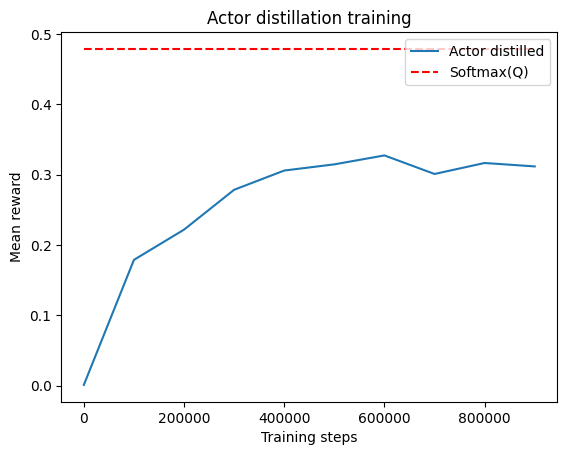

In [41]:
mean_rewards = [info['eval/mean_reward'] for info in eval_infos]
x_axis = jnp.linspace(0, 900_000, 10)
plt.plot(x_axis, mean_rewards, label='Actor distilled')
plt.hlines(eval_info_critic['eval/mean_reward'], xmin=x_axis.min(), xmax=x_axis.max(), colors='r', linestyles='dashed', label="Softmax(Q)")
plt.legend()
plt.ylabel('Mean reward')
plt.xlabel('Training steps')
plt.title('Actor distillation training')

### Generalization tests

In [42]:
eval_general_actor = eval_agent(agent_new, key, config, None, True)
eval_general_q =  eval_agent(agent_new, key, config, 1, True)

In [43]:
mean_reward_general_actor = [eval_general_actor[f'eval_{i}/mean_reward'] for i in range(1,12,2)]
mean_reward_general_q = [eval_general_q[f'eval_{i}/mean_reward'] for i in range(1,12,2)]

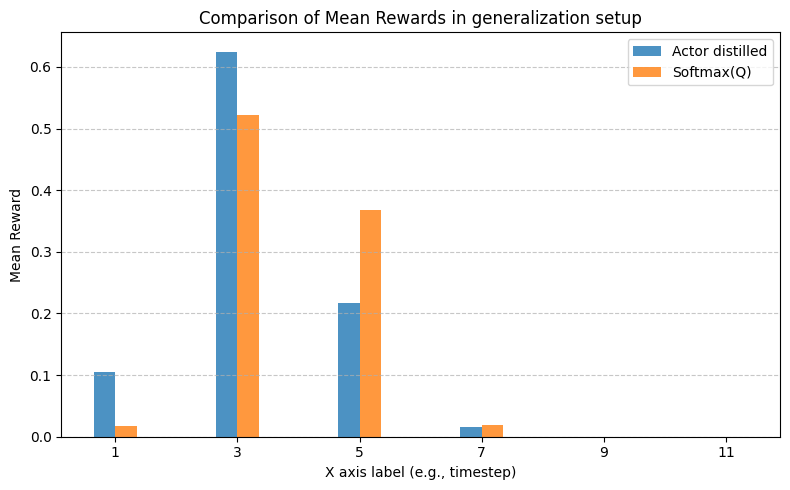

In [44]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(range(1, 12, 2))
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(8,5))

# Shift the bars so they don’t overlap
ax.bar(x - width/2, mean_reward_general_actor, width, label='Actor distilled', alpha=0.8, color='tab:blue')
ax.bar(x + width/2, mean_reward_general_q, width, label='Softmax(Q)', alpha=0.8, color='tab:orange')

ax.set_xlabel('X axis label (e.g., timestep)')
ax.set_ylabel('Mean Reward')
ax.set_title('Comparison of Mean Rewards in generalization setup')
ax.set_xticks(x)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
